---

<div align=center>

# 📜 **Abstract**

</div>

Nulling interferometry $^1$ is a promising technique for direct detection of exoplanets. However, the performance of current devices is limited by the sensitivity to any phase aberrations. The work presented here attempts to overcome those limitations by using a four-telescopes nulling interferometer architecture, called Kernel-Nuller $^2$, which includes a recombiner that positions the four signals in phase quadrature. This architecture is based on an integrated optical component containing 14 electronically controlled phase shifters, used to correct optical path differences that would be induced by manufacturing defects. The first part of the study consists in the development of an algorithm providing the delays to be injected into the component to optimize the performance of that device. The next step of this study deals with the analysis of the intensity distributions produced at the output of the Kernel-Nuller $^{2,3}$ through a series of observations, and then apply statistical tests and data treatment techniques to detect the presence of exoplanets.

> **References**
> 1. Bracewell, R.N., MacPhie, R.H., 1979. Searching for nonsolar planets. Icarus 38, 136–147. https://doi.org/10.1016/0019-1035(79)90093-9
> 2. Martinache, F., Ireland, M.J., 2018. Kernel-nulling for a robust direct interferometric detection of extrasolar planets. A&A 619, A87. https://doi.org/10.1051/0004-6361/201832847
> 3. Cvetojevic, N. et al., 2022. 3-beam self-calibrated Kernel nulling photonic interferometer. arXiv e-prints. https://doi.org/10.48550/arXiv.2206.04977


---

<div align=center>

# **🖥️ Simulation requirements**

</div>

## 📥 Imports

In [1]:
import os
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
import astropy.units as u
import ipywidgets as widgets
from IPython.display import clear_output, display
import fitter
import numba as nb
from scipy.optimize import curve_fit
import tensorflow as tf
from copy import deepcopy as copy

from src import *

## 🎛️ Parameters

<div align=center>
👉 <i><U>Only edit the following block</u></i>
</div>

In [2]:
# Instrument properties
TELESCOPE_RELATIVE_POSITIONS = telescopes.get_VLTI_relative_positions()
COLLECTORS_AREA = 4 * np.pi * (4*u.m)**2
LATITUDE = -24.6275 * u.deg
FOV = 10 * u.mas # Field of view
OPTICAL_EFFICIENCY = 0.01

# Observation conditions
L = 1.65 * u.um # Wavelength
ΔL = 0.3 * u.um # Bandwidth
DECLINATION = -64.71 * u.deg
STAR_MAGNITUDE = 0 * u.mag
H = 0 * u.hourangle # Observation central time
ΔH = 8 * u.hourangle # Observation duration
ΔT = 1 * u.s # Exposure time

# Sources properties
SOURCES = [
    Source('Star', c=1, θ=0 * u.mas, α=0 * u.deg),
    Source('Planet A', c=1e-6, θ=5.23 * u.mas, α=49.68 * u.deg),
    # Source('Planet B', c=1e-3, θ=7 * u.mas, α=-25 * u.deg),
    # Source('Planet C', c=1e-3, θ=3 * u.mas, α=141 * u.deg),
]

# Cophasing errors
INPUT_CE_RMS = 100 * u.nm # ~100 nm for ground based telescopes, 10 to 1 nm for space telescopes
SHIFTS_CE_RMS = 100 * u.nm
SHIFTS_CE_OFFSET = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) * u.nm

# SHIFTS_CE_OFFSET = np.array([1.64214688, 1.64216085, 0.00554631, 1.64884721, 1.62784278, 0.03160111, 0.0182902, 0.02791266, 0.01329669, 0.01020052, 1.63187602, 1.64524911, 0.02049508, 0.0165746]) * L.unit
# SHIFTS_CE_RMS = L*0

Processing parameters (conversion to commonly used units)

In [3]:
TELESCOPE_RELATIVE_POSITIONS = TELESCOPE_RELATIVE_POSITIONS.to(u.m)
LATITUDE = LATITUDE.to(u.deg)
DECLINATION = DECLINATION.to(u.deg)
INPUT_CE_RMS = INPUT_CE_RMS.to(L.unit)
SHIFTS_CE_RMS = SHIFTS_CE_RMS.to(L.unit)
SHIFTS_CE_OFFSET = SHIFTS_CE_OFFSET.to(L.unit)
PARALLACTIC_ANGLE_RANGE = np.linspace(0,2*np.pi,360)*u.rad
EXTENT = (-FOV.value, FOV.value, -FOV.value, FOV.value)
FOV = FOV.to(u.mas)
π = np.pi

STAR_FLUX = signals.photon_flux(
    λ=L,
    Δλ=ΔL,
    f=1050*u.Jy,
    a=COLLECTORS_AREA,
    η=OPTICAL_EFFICIENCY,
    m=STAR_MAGNITUDE,
)

SHIFTS_CE = phase.bound(
    φ=phase.perturb(
        φ=SHIFTS_CE_OFFSET,
        rms=SHIFTS_CE_RMS,
    ),
    λ=L,
)

---

<div align=center>

# 🤔 **Context**

</div>

## 🎯 Goal

We aim to detect make direct detection of exoplanets. There is two main challenges to achieve this goal:
- The **contrast**: the exoplanet is much fainter than the star it orbits. The contrast is typically of the order of $10^{-6}$ to $10^{-10}$.
- The **angular separation**: the exoplanet is very close to the star. The angular separation depend on the distance of the exoplanet to the star and the distance of the star to the observer and can easily goes below the arcsecond.

## 🔎 Detection methods

It exist several methods to detect exoplanets. The most common are:
- **Radial velocity method**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the Doppler effect (the light is alternatively redshifted and blueshifted).
- **Transit method**: the exoplanet pass in front of the star and block a fraction of the light. This fraction can be detected by the decrease of the star luminosity.
- **Microlensing**: the exoplanet act as a lens and magnify the light of a background star. This magnification can be detected by the increase of the star luminosity.
- **Astrometry**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the change of the star position.
- **Coronography**: the exoplanet is directly imaged. This is the most challenging method because of the contrast and the angular separation.

<div align=center>
<img src="img/detection_methods.jpg" width=500px>
<p><i>Paul Anthony Wilson - Exoplanet detection techniques</i><p>
</div>

Until now, the coronography was the only method allowing direct detection. But it has two main limitations:
- It require huge telescopes in order to have a good angular resolution.
- The contrast we can achieve is limited by unperfect fabrication process of the optical components which lead to undesired diffraction effects.

## ➖ Nulling

This is where the Nulling technic $^1$ come into play. The idea is to use two several telescopes and take advantage of destructives interferances to cancel the star light and using the fact that the planet is not perfectly in the line of sight, which will lead to an unperfect destructive interference, or in best scenarios, on constructive ones! This is a very challenging technic because it is highly phase sensitive and require a very good control of the optical path.

<div align=center>
<img src="img/nulling_principle.jpg" width=500px>
</div>

In a perfect 2-telescope nulling system, we can express the two acquired electric field (cf. section "Signal nature" below) in a vector:

$$
E = \begin{pmatrix}
E_1 \\
E_2
\end{pmatrix}
$$

And then express the nulling operation using the following matrix:

$$
N = \begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}
$$

Such as it gives us two outputs with a constructive and a destructive interference (we will focus on the latter):

$$
N \cdot E = \begin{pmatrix}
E_1 + E_2 \\
E_1 - E_2
\end{pmatrix}
$$

> **References**
> 1. Bracewell, R.N., MacPhie, R.H., 1979. Searching for nonsolar planets. Icarus 38, 136–147. https://doi.org/10.1016/0019-1035(79)90093-9

cf. `mmi.py`

## 📡 Projected telescope position

The interferometry process depend on the projected geometry of the telescope position in the plane perpendicular to the line of sight. For each observation, we will then need to compute these projected positions in order to have the correct baseline lenght (and thus the correct phase shifts).\
These projected location can be computed using the following formula $^{1,2}$:

$$
\begin{pmatrix}
u \\
v
\end{pmatrix} =
\begin{pmatrix}
- \sin(l) \sin(h) & \cos(h)\\
\sin(l) \cos(h) \sin(\delta) + \cos(l) \cos(\delta) & \sin(h) \sin(\delta)
\end{pmatrix}
\begin{pmatrix}
B_\text{north} \\
B_\text{east}
\end{pmatrix}
$$

with
- $l$ the latitude of the observatory
- $h$ the hour angle
- $\delta$ the declination of the star

> *Rerefence*
> 1. Chingaipe, P.M. et al., 2023. High-contrast detection of exoplanets with a kernel-nuller at the VLTI. A&A 676, A43. https://doi.org/10.1051/0004-6361/202346118
> 2. Ségransan, D., 2007. Observability and UV coverage. New Astronomy Reviews 51, 597–603. https://doi.org/10.1016/j.newar.2007.06.005

cf. `telescopes.py`

In [4]:
# telescopes.plot_positions(
#     r=TELESCOPE_RELATIVE_POSITIONS,
#     h=H,
#     Δh=ΔH,
#     l=LATITUDE,
#     δ=DECLINATION,
# )

## 🔆 Signal nature

The star and the planet are point sources. Seen from a classical telescope, it will result in an image made of the objects convolution with the point spread function (PSF) of the telescope.

$$
I = O \otimes PSF
$$

Here we consider the most simple PSF : the Airy disk. The Airy disk is the diffraction pattern of a point source by a circular aperture. It is given by:

$$
PSF = \left(\frac{2J_1(x)}{x}\right)^2
$$

where $J_1$ is the Bessel function of the first kind of order 1 and $x = \frac{2\pi r}{\lambda f}$ is the normalized radius of the Airy disk.

Then, we focus the image in a monomode optical fiber which will basically only keep the main lobe of the PSF and reshape it in a Gaussian form. In this process, we lose the spatial information so we have no longer images, but the light flux of each object in the fiber can be simply described by a complex number.

Using this formalism, the light flux of the star and the planet can  be described by only 2 complex numbers for each telescope, giving the amplitude and phase of each object.

cf. `signals.py`

## 🔉 Photon noise

The photon noise is the noise due to the quantization of the light in photons. It is a Poisson noise and can be described by the following formula:

$$
\sigma = \sqrt{N}
$$

where $N$ is the number of photons.

The number of photons can be computed using the Light flux $F_\lambda$ of the star and the planet, the collecting area $A$ of the telescope, the bandwidth $\Delta \lambda$, the transmission efficiency $\eta$, the magnitude $M$ of the star, and the energy of a photon $E_\nu$ at the frequency $\nu$.

Light flux is expressed in Jensky:
$$
1\:\text{Jensky} = 1\:Jy = 10^{-26}\:W/m^2/Hz = 10^{-26}\:J/s/m^2/Hz
$$
The flux at zero magnitude $F_\lambda$ for a star at different wavelengths is given by tables. The following one is an example for AB class stars such as Vega $^1$:

| Band | $\lambda$ ($\mu m$) | $F_\lambda$ ($Jy$) |
|------|---------------------|--------------------|
| V    | 0.55                | 3540               |
| J    | 1.21                | 1630               |
| H    | 1.65                | 1050               |
| K    | 2.17                | 655                |
| L    | 3.55                | 276                |

The number of acquired photons per second is given by:

$$
N = F_\lambda \times A \times \Delta \nu \times \eta \times 10^{-\frac{M}{2.5}} / E_\nu
$$

where $A$ is the collecting area of the telescope, $\Delta \nu$ is the bandwidth, $\eta$ is the transmission efficiency of the system, $M$ is the magnitude of the star, and $E_\nu$ is the energy of a photon at the frequency $\nu$.

We can also express the bandwidth and eneergy in terms of the wavelength:
$$
\Delta \nu = \frac{c}{\lambda^2} \Delta \lambda
$$
$$
E_\nu = \frac{h \times c}{\lambda}
$$

where $c$ is the speed of light, $h$ is the Planck constant.

> **References**
> 1. Allen's Astrophysical Quantities

cf. `signals.py`

## 🏮 MMI

The nulling operation is made using Multi Mode Interferometer (MMI). It consist in a multimode waveguide taking several monomode fibers as input and output. The multimode waveguide is shaped in order to produce a specific interference operation, such as spreading the light of an input on all the output, or opposite, gathering the light of all the input on a single output.

To design a simple nuller, we then need a 2x2 MMI that gather (ie. create a constructive interference) all the input light on a single output. The other output is then a "nulled" output, where there is actually all the inputs light but in phase opposition, resulting in a destructive interference.

<div align=center>
<img src="img/mmi.png" width=400px>

*Numerical simulation of a 3x3 gathering MMI, taken from the paper of Cvetojevic et. al., 2022 $^1$*

</div>

> **Reference**
> 1. Cvetojevic, N. et al., 2022. 3-beam self-calibrated Kernel nulling photonic interferometer. arXiv e-prints. https://doi.org/10.48550/arXiv.2206.04977

## 🔀 Recombiner

The recombiner is also an MMI that will place the signals in phase quadrature. A particularity is that the output of the recombiner contain a symmetry. We will take advantage of this in the Kernel step.

<div align=center>
<img src="img/recombiner.png" width=500px>

*Action of a 2x2 recombiner MMI, taking 2 different combination of 4 nulled signals as input. Taken from the paper of Romain Laugier et al., 2020 $^1$*

</div>

In a 2 input case, we can express the recombiner operation using the following matrix:

$$  
R = \frac{1}{\sqrt{2}}\begin{pmatrix}
e^{i\pi/4} & e^{-i\pi/4} \\
e^{-i\pi/4} & e^{i\pi/4}
\end{pmatrix}
$$

> **Reference**
> 1. Laugier, R., Cvetojevic, N., Martinache, F., 2020. Kernel nullers for an arbitrary number of apertures. A&A 642, A202. https://doi.org/10.1051/0004-6361/202038866

cf. `mmi.py`


## 💠 Kernel

The idea of the kernel is to acquire and substract the pairs of recombined output. As these pairs share symmetrical properties, this substraction will cancel the star light even with first order phase aberations while keeping the planet light!

Moreover, it modify the nuller response (cf. "Transmission maps" section below) in an asymetric way which is interesting for us as it gives us more information to constrain the planet position.

Demonstration (cf. `demonsration.py`):

In [5]:
# demonstration.show()

## 🌡️ Thermo-optic phase shifter

In practice, we are often limited by the fabrication process of the optical components. The imperfections can lead into phase aberations that will degrade the Kernel-Nuller performance. An attempt to correct these aberations consist in using thermo-optic phase shifters. It consist in a waveguide with a heater that will modify the refractive index of the waveguide and thus the phase of the light passing through it.

As the size of the waveguide is very small, the thermal inertia is very low and the phase can be modified very quickly, in a milisecond time scale. This is a very interesting solution to correct phase aberations, even in real time if we encounter variable phase aberation sources.

<div align=center>
<img src="img/thermo-optic_phase_shifter.png" width=500px>
</div>

In this simulation, one will simply modelize these phase shifter as a phase shift in the signal.

$$
P = e^{i\phi} = e^{i\frac{2\pi}{\lambda} \Delta L}
$$

Where $\phi$ and $\Delta L$ are proportional to the power injected in the heater.

cf. `phase.py`

---

<div align=center>

# 💡 **Our approach**

</div>

## 🏗️ Current architecture

To implement the 4 telescope tunable Kernel-Nuller, we splitted the 4x4 MMI into series of 2x2 MMI separated by phase shifters.

<div align=center>
<img src="img/scheme.png" width=1000px>

*Architecture of our Kernel-Nuller. N suqares are the 2x2 nullers, S squares are the 2x2 recombiners and P rectangles are the phase shifters*

</div>

cf. `kn.py`

d:\Tunable-Kernel-Nulling\src\modules\telescopes.py:96: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  r_projected[i] = M @ np.flip(pos)


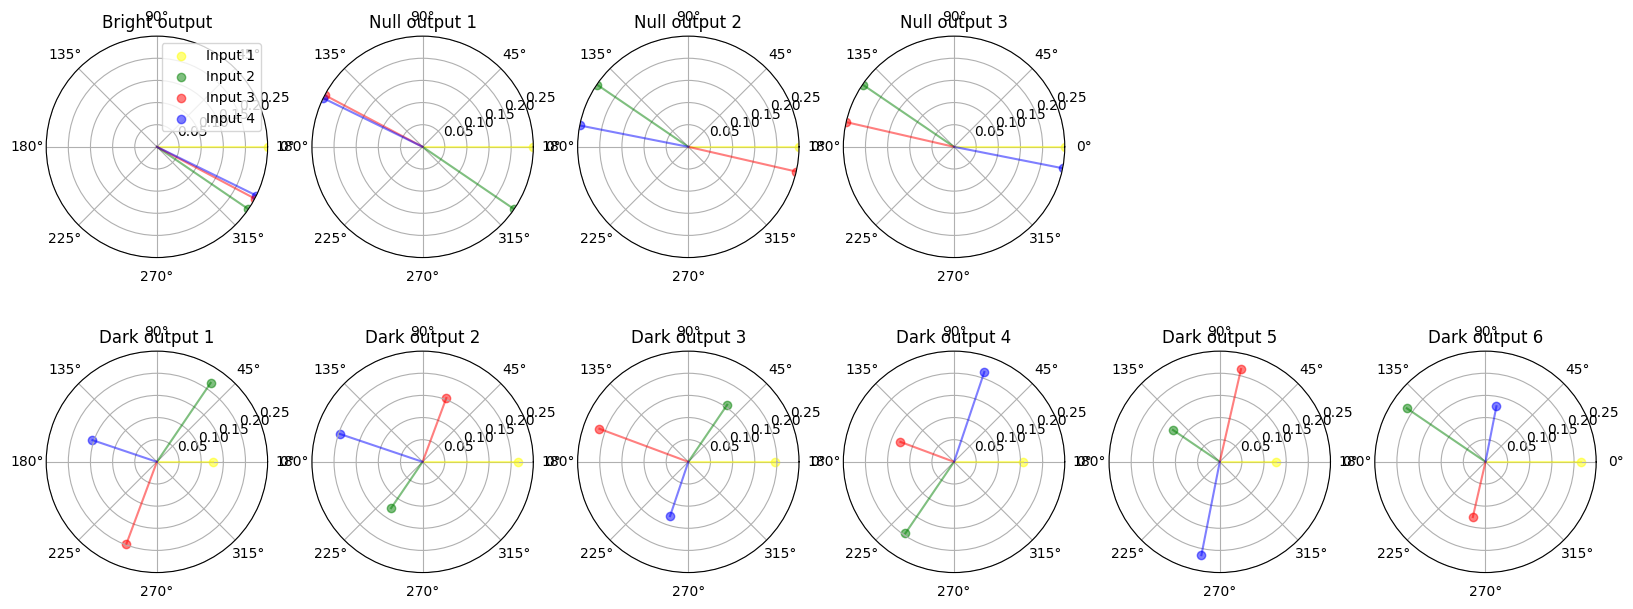

In [6]:
SCENE_PERTURBED = Scene(
    instrument=Instrument(
        λ=L,
        Δλ=ΔL,
        r=TELESCOPE_RELATIVE_POSITIONS,
        l=LATITUDE,
        fov=FOV,
        kn= KernelNuller(
            φ = np.zeros(14) * L.unit,
            σ = SHIFTS_CE
        ),
    ),
    δ=DECLINATION,
    h=H,
    Δh=ΔH,
    f=STAR_FLUX,
    Δt=ΔT,
    input_ce_rms=INPUT_CE_RMS,
    sources=SOURCES,
)

SCENE_PERTURBED.kn.plot_phase(λ=L)

## 🗺️ Transmission maps

The nulling technic with two telescope show a limitation: if the planet light arrive on the two telescopes with a phase shift of $2n\pi$, the light will also be cancelled. It result in a comb-shaped transmission map $^1$, perpendicular to the baseline (there is clear bands where it's optimal to detect the planet and black bands where we will mostly destroy the planet light).

The idea of Bracewell was to rotate the baseline in order to let the planet pass through the clear bands at some point. After an entire rotation of the baseline, we will have a sinusoidal signal from which the frequency will indicate us the distance of the planet to it's star, and the phase will give us a clue about the angle between the axes star-planet and the axes of the baseline. Thus, as the transmission map is symmetric, we can constrain the planet position to 2 possible locations, on both sides of the star.

Here, we are using 4 telescopes, resulting in more complexe transmission maps than simple combs, but the principle is the same.

> **Reference**
> 1. Bracewell, R.N., MacPhie, R.H., 1979. Searching for nonsolar planets. Icarus 38, 136–147. https://doi.org/10.1016/0019-1035(79)90093-9

cf. `transmission_map.py`

In [7]:
SCENE_IDEAL = SCENE_PERTURBED.copy(σ=np.zeros(14) * L.unit)

SCENE_IDEAL.iplot_transmission_maps(N=100)

---

<div align=center>

# 🪛 **Calibration**

</div>

## 🫳 Manual shift controls

In [8]:
def manual_shift_control():
    step = 1e-20

    # Build sliders -----------------------------------------------------------

    # Input amplitude
    IA_sliders = [
        widgets.FloatSlider(
            value=0.5, min=0, max=0.5, step=step, description=f"I{i+1}",
            continuous_update=False,
        )
        for i in range(4)
    ]

    # Input phase
    IP_sliders = [
        widgets.FloatSlider(
            value=0, min=0, max=L.value, step=step, description=f"I{i+1}",
            continuous_update=False,
        )
        for i in range(4)
    ]

    # Shifter phase
    P_sliders = [
        widgets.FloatSlider(
            value=0, min=0, max=L.value, step=step, description=f"P{i+1}",
            continuous_update=False,
        )
        for i in range(14)
    ]

    # for i in range(14):
    #     P_sliders[i].value = KN_OBS.φ[i].value


    # Build GUI ---------------------------------------------------------------

    def beam_repr(beam: complex) -> str:
        return f"<b>{np.abs(beam):.2e}</b> * exp(<b>{np.angle(beam)/np.pi:.2f}</b> pi i)"

    inputs = [widgets.HTML(value=f" ") for _ in range(4)]
    null_outputs = [widgets.HTML(value=f" ") for _ in range(4)]
    dark_outputs = [widgets.HTML(value=f" ") for _ in range(6)]
    kernel_outputs = [widgets.HTML(value=f" ") for _ in range(3)]

    kn = KernelNuller(
        φ = np.zeros(14) * L.unit,
        σ = SHIFTS_CE
    )

    def update_gui(*args):

        ψ = np.array([
            IA_sliders[i].value * np.exp(1j * IP_sliders[i].value / L.value * 2 * np.pi)
            for i in range(4)
        ])

        n, d, b = kn.propagate_fields(ψ=ψ, λ=L)

        k = np.array([
            np.abs(d[2*i])**2 - np.abs(d[2*i+1])**2
        for i in range(3)])

        for i, beam in enumerate(ψ):
            inputs[i].value = (
                f"<b>Input {i+1} -</b> Amplitude: <code>{beam_repr(beam)}</code> Intensity: <code><b>{np.abs(beam)**2*100:.1f}%</b></code>"
            )
        null_outputs[0].value = (
            f"<b>N3a -</b> Amplitude: <code>{beam_repr(b)}</code> Intensity: <code><b>{np.abs(b)**2*100:.1f}%</b></code> <b><- Bright channel</b>"
        )
        for i, beam in enumerate(n):
            null_outputs[i + 1].value = (
                f"<b>N{(i-1)//2+4}{['a','b'][(i+1)%2]} -</b> Amplitude: <code>{beam_repr(beam)}</code> Intensity: <code><b>{np.abs(beam)**2*100:.1f}%</b></code>"
            )
        for i, beam in enumerate(d):
            dark_outputs[i].value = (
                f"<b>Dark {i+1} -</b> Amplitude: <code>{beam_repr(beam)}</code> Intensity: <code><b>{np.abs(beam)**2*100:.1f}%</b></code>"
            )
        for i, beam in enumerate(k):
            kernel_outputs[i].value = (
                f"<b>Kernel {i+1} -</b> Value: <code>{beam:.2e}</code>"
            )   
            
        # fig, ax = plt.subplots(1, 1, figsize=(5, 5))

        phases.value = kn.plot_phase(λ=L, plot=False)

        # Plot intensities
        for i in range(len(ψ)):
            plt.imshow([[np.abs(ψ[i])**2,],], cmap="hot", vmin=0, vmax=np.sum(np.abs(ψ)**2))
            plt.savefig(fname=f"img/tmp.png", format="png")
            plt.close()
            with open("img/tmp.png", "rb") as file:
                image = file.read()
                photometric_cameras[i].value = image
        for i in range(len(n)+1):
            if i == 0:
                plt.imshow([[np.abs(b)**2,],], cmap="hot", vmin=0, vmax=np.sum(np.abs(n)**2) + np.abs(b)**2)
            else:
                plt.imshow([[np.abs(n[i-1])**2,],], cmap="hot", vmin=0, vmax=np.sum(np.abs(n)**2) + np.abs(b)**2)
            plt.savefig(fname=f"img/tmp.png", format="png")
            plt.close()
            with open("img/tmp.png", "rb") as file:
                image = file.read()
                null_cameras[i].value = image
        for i in range(len(d)):
            plt.imshow([[np.abs(d[i])**2,],], cmap="hot", vmin=0, vmax=np.sum(np.abs(d)**2))
            plt.savefig(fname=f"img/tmp.png", format="png")
            plt.close()
            with open("img/tmp.png", "rb") as file:
                image = file.read()
                dark_cameras[i].value = image
        for i in range(len(k)):
            plt.imshow([[k[i],],], cmap="bwr", vmin=-np.max(np.abs(k)), vmax=np.max(np.abs(k)))
            plt.savefig(fname=f"img/tmp.png", format="png")
            plt.close()
            with open("img/tmp.png", "rb") as file:
                image = file.read()
                kernel_cameras[i].value = image

        os.remove("img/tmp.png")

        return b, d
    
    photometric_cameras = [widgets.Image(width=50,height=50) for _ in range(4)]
    null_cameras = [widgets.Image(width=50,height=50) for _ in range(4)]
    dark_cameras = [widgets.Image(width=50,height=50) for _ in range(6)]
    kernel_cameras = [widgets.Image(width=50,height=50) for _ in range(3)]
    phases = widgets.Image()

    vbox = widgets.VBox(
        [
            widgets.HTML("<h1>Inputs</h1>"),
            widgets.HTML("Amplitude:"),
            widgets.HBox(IA_sliders[:4]),
            widgets.HTML("Phase:"),
            widgets.HBox(IP_sliders[:4]),
            *[widgets.HBox([photometric_cameras[i], x]) for i, x in enumerate(inputs)],
            widgets.HTML("<h1>Phases</h1>"),
            phases,
            widgets.HTML("<h1>Nuller</h1>"),
            widgets.HBox(P_sliders[:4]),
            widgets.HBox(P_sliders[4:8]),
            *[widgets.HBox([null_cameras[i], x]) for i, x in enumerate(null_outputs)],
            widgets.HTML("<h1>Recombiner</h1>"),
            widgets.HBox(P_sliders[8:11]),
            widgets.HBox(P_sliders[11:14]),
            *[widgets.HBox([dark_cameras[i], x]) for i, x in enumerate(dark_outputs)],
            widgets.HTML("<h1>Kernels</h1>"),
            *[widgets.HBox([kernel_cameras[i], x]) for i, x in enumerate(kernel_outputs)],
        ]
    )

    # Link sliders to update function ------------------------------------------

    for widget in P_sliders:
        widget.observe(update_gui, "value")
    for widget in IA_sliders:
        widget.observe(update_gui, "value")
    for widget in IP_sliders:
        widget.observe(update_gui, "value")

    update_gui()
    return vbox

manual_shift_control()

## 👁️ Obstruction

En obstruant successivement une paire d'entrées, il est possible de simplifier le problème d'optimisation en ne jouant que sur un seul paramètre et en ne regardant qu'une seule sortie.

Il existe différentes façon de procéder. Je ne vais détailler ici que l'une d'entre elles.

On commence par obstruer les entrées $I_2$ et $I_3$. Au regard de l'architectue de notre composant, on peut alors décrire la fonction de transfert pour la sortie brillante $B$

$$
B = \left|\left(a_1 e^{i(\theta_1 + \sigma_1 + \phi_1)} + a_2 e^{i(\theta_2 + \sigma_2 + \phi_2)}\right) e^{i(\sigma_5 + \phi_5)}\right|^2
$$

Où $a_n$ et $\theta_n$ représentent respectivement l'amplitude et la phase des signaux d'entrée. $\sigma_n$ correspond à la perturbation de phase (inconnue) associé au retardateur $n$ et $\phi_n$ est la phase que l'on inject volontairement via le retardateur pour tenter de compenser cette perturbation.

La calibration se faisant en laboatoire, on peut supposer une intensité totale fixée à $1$ (unité arbitraire) et que chaque entrée recçoi le même flux soit $a_1 = a_2 = 1/\sqrt{2}$, et parfaitement cophasé, soit $\theta_1 = \theta_2 = \theta$. Etant donné que l'on a accès qu'a l'intensité du signal, nous sommes insensible à la phase globale, ce qui permet de simplifier l'équation précédente :

$$
B = \frac{1}{2} \left|e^{i(\sigma_1 + \phi_1)} + e^{i(\sigma_2 + \phi_2)}\right|^2
$$

En maximisant $B$, on devrait alors trouver $1$ ce qui implique que

$$
\sigma_1 + \phi_1 = \sigma_2 + \phi_2
$$

On peut utiliser $\phi_1$ comme référence (phase globale) et ainsi le fixer à 0, ce qui donne alors

$$
\phi_2 = \sigma_1 - \sigma_2
$$

On peut alors soit effectuer différentes mesures de $B$ à $\phi_2$ fixé et en déduire $\sigma_1$ et $\sigma_2$ par résolution d'un système déquation, soit trouver dichotomiquement la valeur de $\phi_2$ qui maximise $B$.

6e+09 1 / s


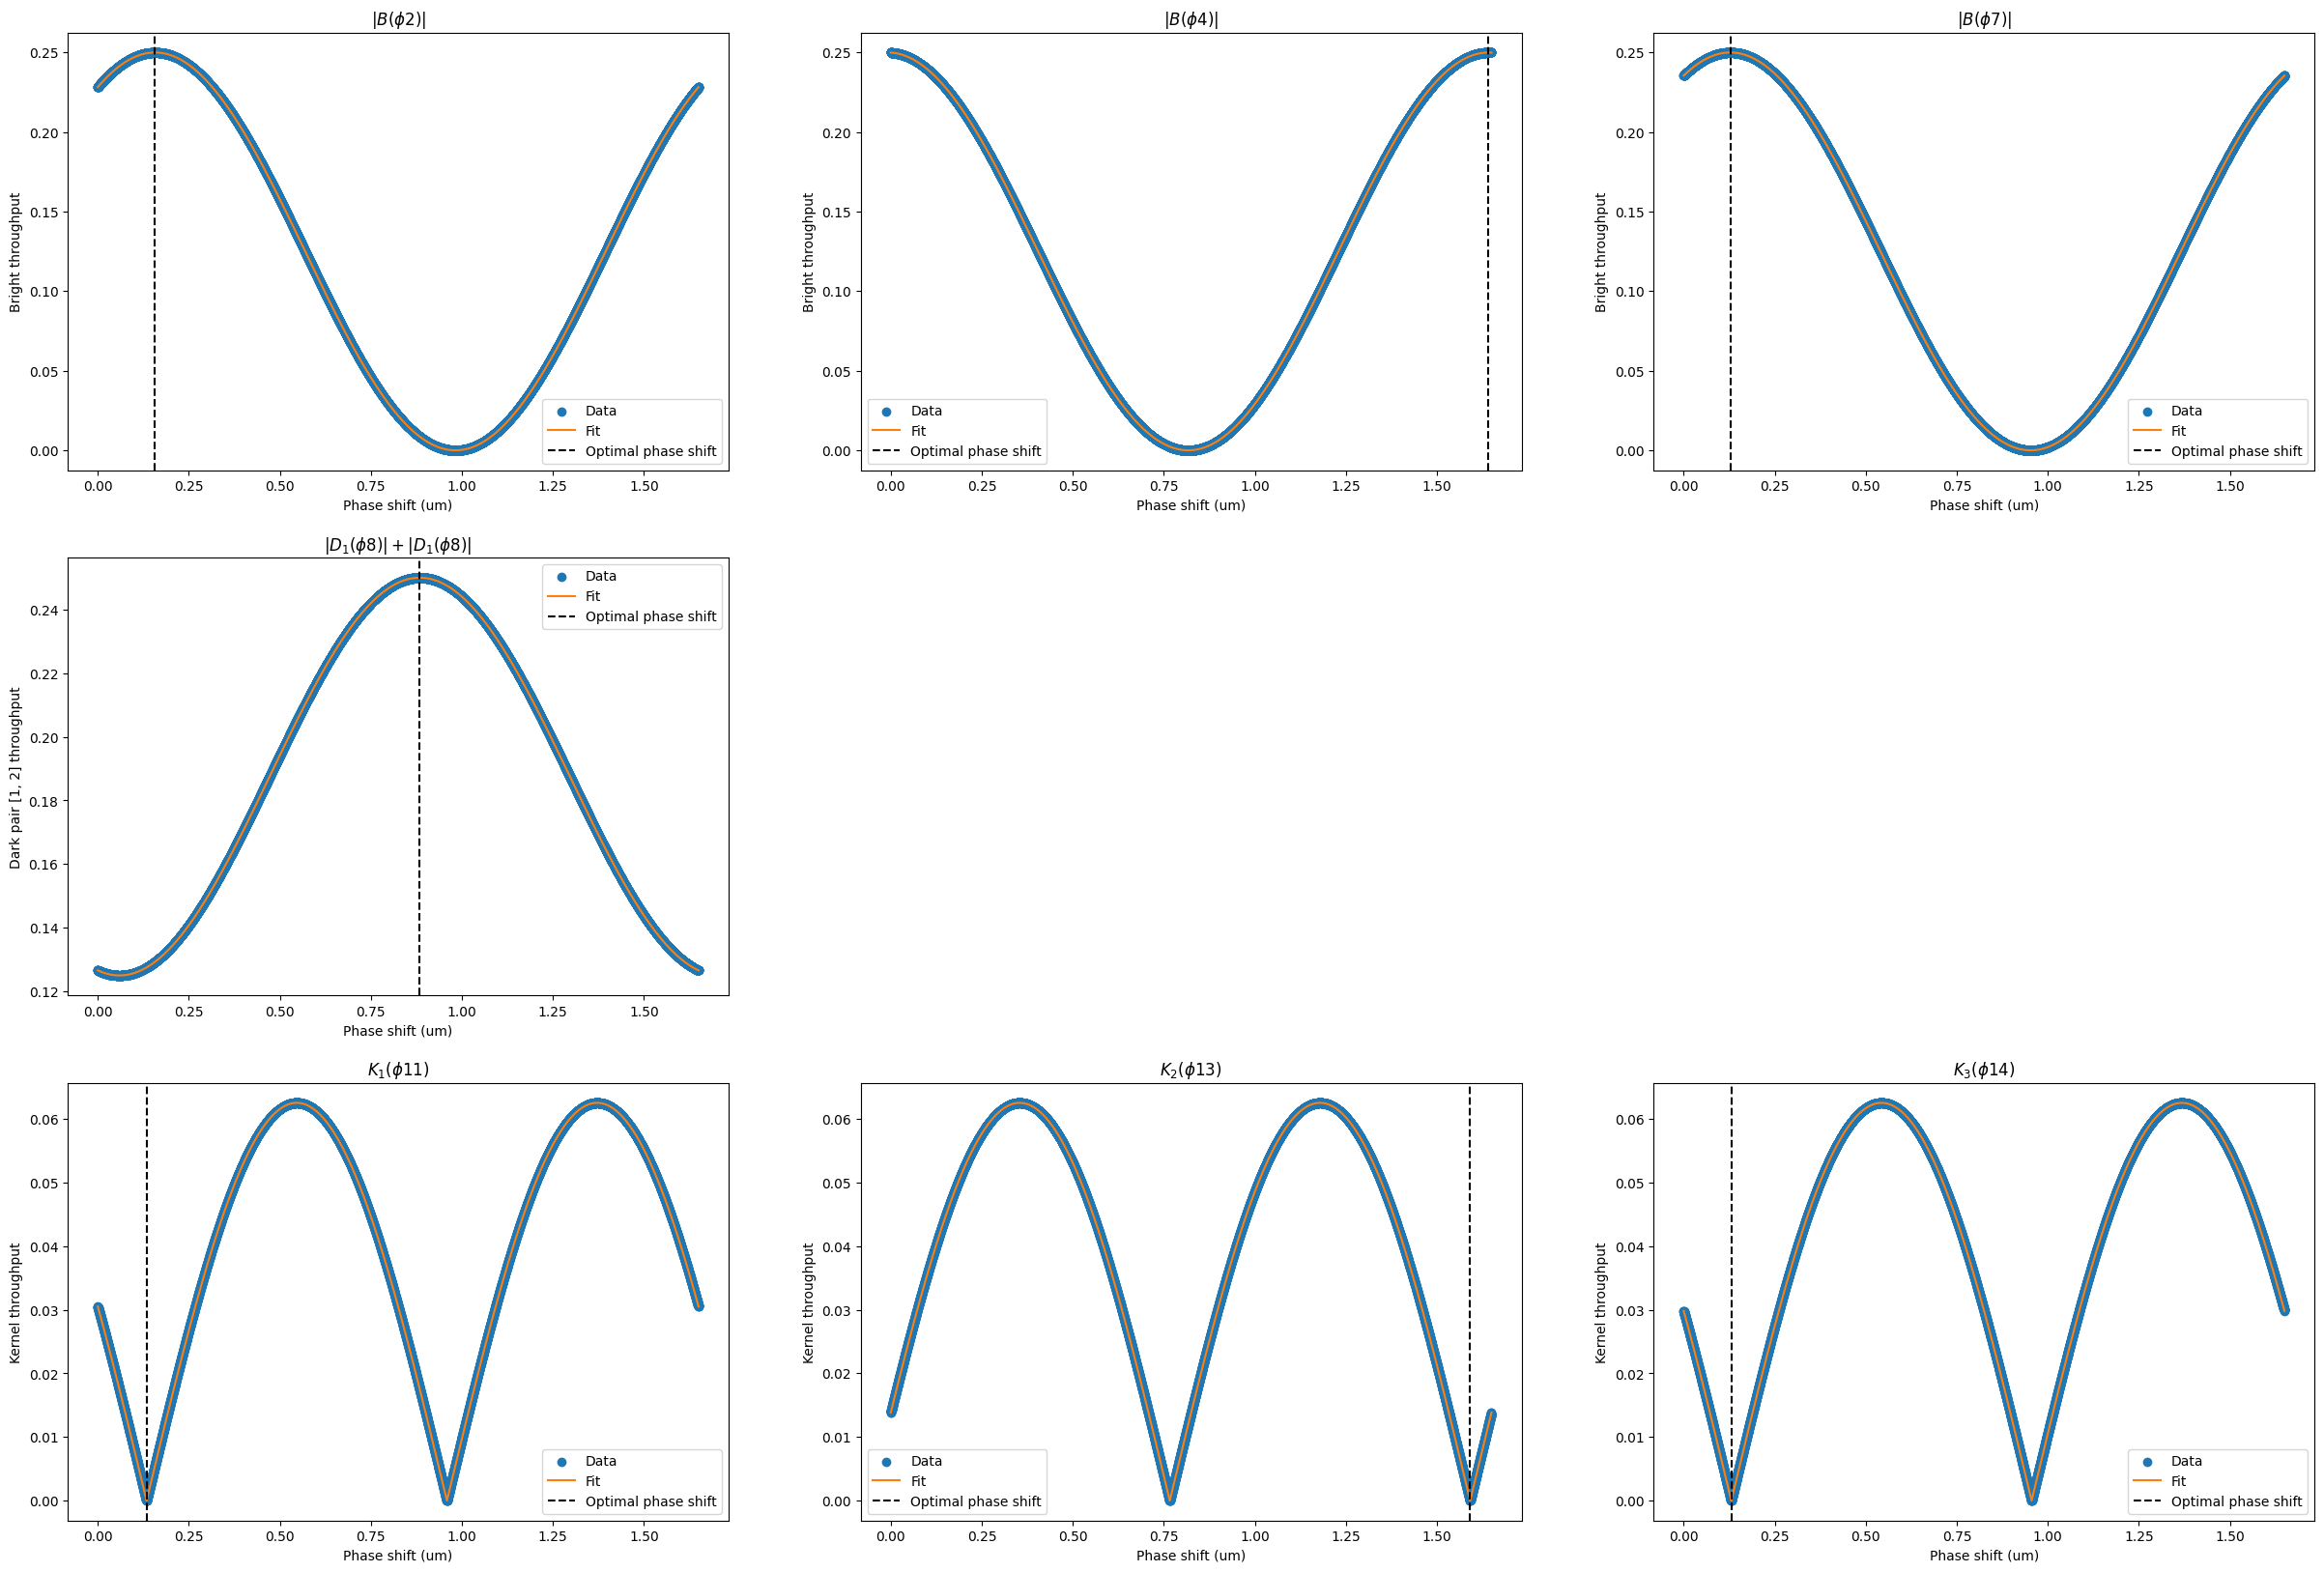

In [9]:
SCENE_OBS = SCENE_PERTURBED.copy()

f2 = STAR_FLUX#/10_000_000
print(f"{f2:.0e}")

calibration.obstruction(kn=SCENE_OBS.kn, λ=L, f=f2, Δt=ΔT, N= 10_000, plot=True)
# KN_OBS.plot_phase(λ=L)
# SCENE_OBS.plot_transmission_maps(N=100)

## 🧬 Genetic

in order to get the best shifts to inject to optimize the component performances, I made a genetic algorithme that iteratively mutate a shifter and keep the mutation if it minimize the associated metric. All the shifters that act on the bright channel are associated with the bright metric that must be maximized

$$
M_B = |B|^2
$$

While the other shifters are associated with the kernel metric that must be minimized.

$$
M_K = \sum_{n=1}^3|K_n|
$$

Merging these two metrics can induce local minimum since improving the bright metric can deterior the kernel metric. This separation is then necessary to ensure reaching a global minimum (empirically demonstrated)

> **Acknowledgment**
> - Romain Laugier for the idea of merging the metrics

7.480296820374548e-08


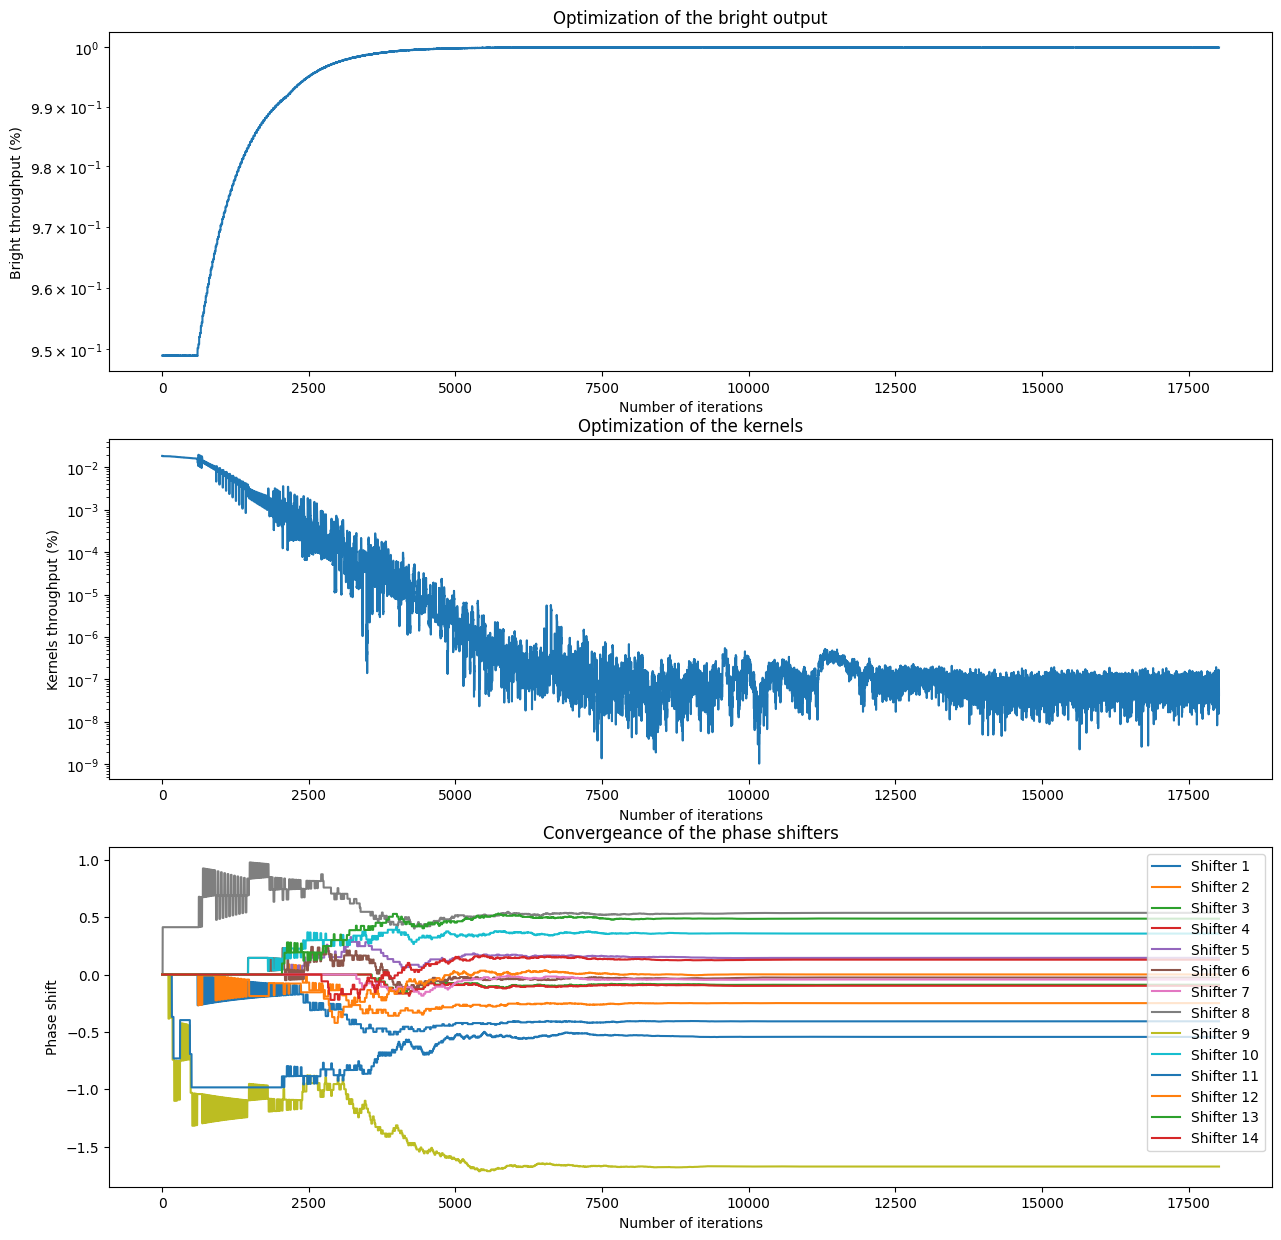

(<src.classes.kernel_nuller.KernelNuller at 0x29d974894d0>,
 {'bright': array([0.94900063, 0.948996  , 0.94899535, ..., 0.9999899 , 0.9999901 ,
         0.99998523]),
  'kernel': array([1.85602496e-02, 1.85691925e-02, 1.85713444e-02, ...,
         7.31923059e-08, 8.82105385e-08, 4.29832174e-08]),
  'shifters': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-0.40769962, -0.24917364, -0.08863092, ...,  0.00068882,
           0.48653369,  0.12903172],
         [-0.40769962, -0.24917364, -0.08863092, ...,  0.00068982,
           0.48653369,  0.12903172],
         [-0.40769962, -0.24917364, -0.08863092, ...,  0.00068982,
           0.48653369,  0.12903172]])})

In [10]:
SCENE_GEN = SCENE_PERTURBED.copy()

calibration.genetic(kn=SCENE_GEN.kn, β=0.99, λ=L, f=STAR_FLUX, Δt=ΔT, verbose=False, plot=True)
# SCENE_GEN.instrument.kn.plot_phase(λ=L)
# SCENE_GEN.plot_transmission_maps(N=100)

## 🧐 Comparison

In [11]:
# calibration.compare_approaches(f=STAR_FLUX, Δt=ΔT, λ=L)

## 🤖 Machine Learning

Another approach to retrieve the correct shifts inject is to use machine learning techniques. There is several ways to do so. Here we will focus a supervised dense neural network. To do so, we will have to build a dataset.

As the solutions are degenerated, we will not ask the network to predict the best shift to inject, but we will ask it to predict the shfit aberrations instead. From these aberation, we are able to determine a solution for the shifts to inject.

As input of the network, we need to give enough information to caracterize the parameter space. The most straightforward approach would be to create a grid in the parameter space and give the kenrel outputs for each of the point in these grid.

Unfortunately, we work in a parameter space of 14 dimensions which is too large to be covered by a grid. A solution is to consider only the vectors that form the cardinal basis of this parameter space.

In [12]:
# TODO: refactor the following code
# DATASET = ml.get_dataset(10_000)
# print(DATASET.shape)
# MODEL = ml.get_model(input_shape=DATASET.shape[1]-14)
# MODEL.summary()
# ml.train_model(plot=True)
# ml.test_model()

## 🎭 Shifters correlation

In [13]:
def scan_on(φ1=1, φ2=2):
    calibration.scan(scan_on=(φ1, φ2), kn=SCENE_OBS.kn, λ=L, restricted=True)
    calibration.scan(scan_on=(φ1, φ2), kn=SCENE_OBS.kn, λ=L, restricted=False)

# scan_on(1, 2)

---

<div align=center>

# ⚙️ **Data generation**

</div>

First, let's generate the different scenes we will compare:

## 🟨 Instantaneous serie

In [14]:
H0_IDEAL_INSTANT_SERIE = SCENE_IDEAL.copy(input_ce_rms=100*u.nm, sources=SOURCES[0]).instant_serie_observation(N=1000)
H1_IDEAL_INSTANT_SERIE = SCENE_IDEAL.copy(input_ce_rms=100*u.nm).instant_serie_observation(N=1000)
H1_PERTURBED_INSTANT_SERIE = SCENE_PERTURBED.copy(input_ce_rms=100*u.nm).instant_serie_observation(N=1000)
H1_OBS_INSTANT_SERIE = SCENE_OBS.copy(input_ce_rms=100*u.nm).instant_serie_observation(N=1000)
H1_GEN_INSTANT_SERIE = SCENE_GEN.copy(input_ce_rms=100*u.nm).instant_serie_observation(N=1000)

for output in H1_IDEAL_INSTANT_SERIE.keys():
    H0_IDEAL_INSTANT_SERIE[output] /= STAR_FLUX * ΔT
    H1_IDEAL_INSTANT_SERIE[output] /= STAR_FLUX * ΔT
    H1_PERTURBED_INSTANT_SERIE[output] /= STAR_FLUX * ΔT
    H1_GEN_INSTANT_SERIE[output] /= STAR_FLUX * ΔT
    H1_OBS_INSTANT_SERIE[output] /= STAR_FLUX * ΔT

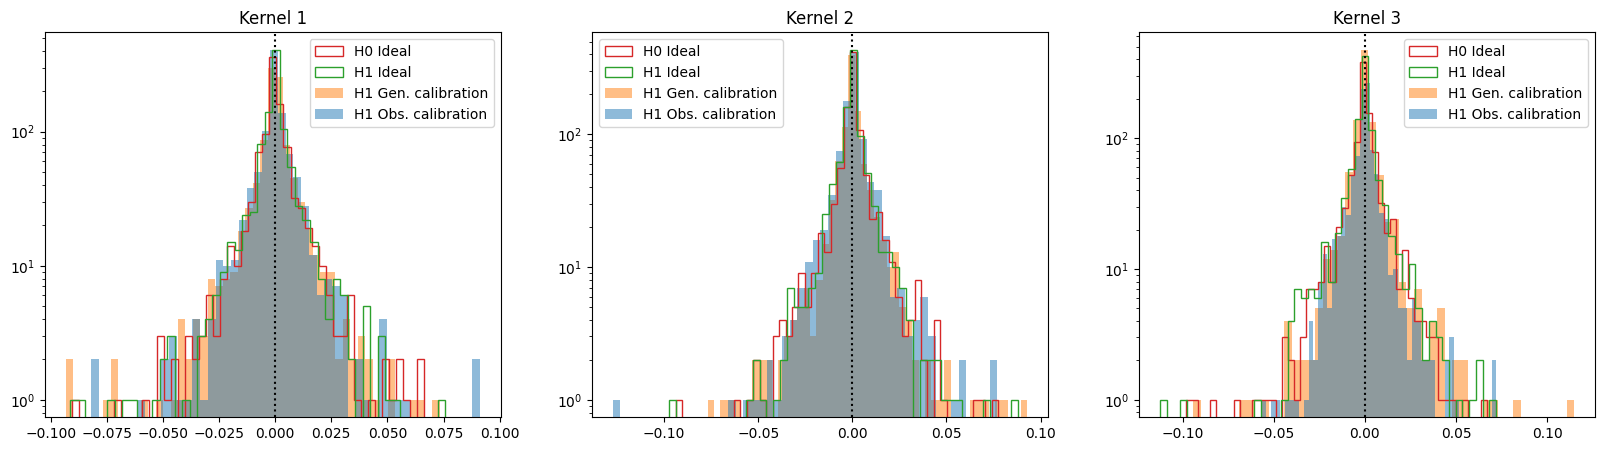

In [15]:
def plot_instant_serie():
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    for k in range(3):
        axs[k].set_title(f'Kernel {k+1}')
        axs[k].hist(H0_IDEAL_INSTANT_SERIE['kernels'][:,k], bins=50, alpha=1, label='H0 Ideal', color='tab:red', log=True, histtype='step')
        axs[k].hist(H1_IDEAL_INSTANT_SERIE['kernels'][:,k], bins=50, alpha=1, label='H1 Ideal', color='tab:green', log=True, histtype='step')
        # axs[k].hist(PERTURBED_INSTANT_SERIE['kernels'][:,k], bins=50, alpha=0.5, label='Perturbed', color='tab:red', log=True, histtype='step', linestyle='dashed')
        axs[k].hist(H1_GEN_INSTANT_SERIE['kernels'][:,k], bins=50, alpha=0.5, label='H1 Gen. calibration', color='tab:orange', log=True)
        axs[k].hist(H1_OBS_INSTANT_SERIE['kernels'][:,k], bins=50, alpha=0.5, label='H1 Obs. calibration', color='tab:blue', log=True)
        axs[k].axvline(0, color='black', linestyle='dotted')
        axs[k].legend()
    plt.show()
plot_instant_serie()

Curve-fit: 0.11474230447618389
Least Square: 0.06554810428038267
Least Absolute: 0.0920976569025827
Curve-fit: 0.09805739649992246
Least Square: 0.06098286972638567
Least Absolute: 0.0713919490669943
Curve-fit: 0.07350396950408168
Least Square: 0.05532549147597543
Least Absolute: 0.058758888661831474


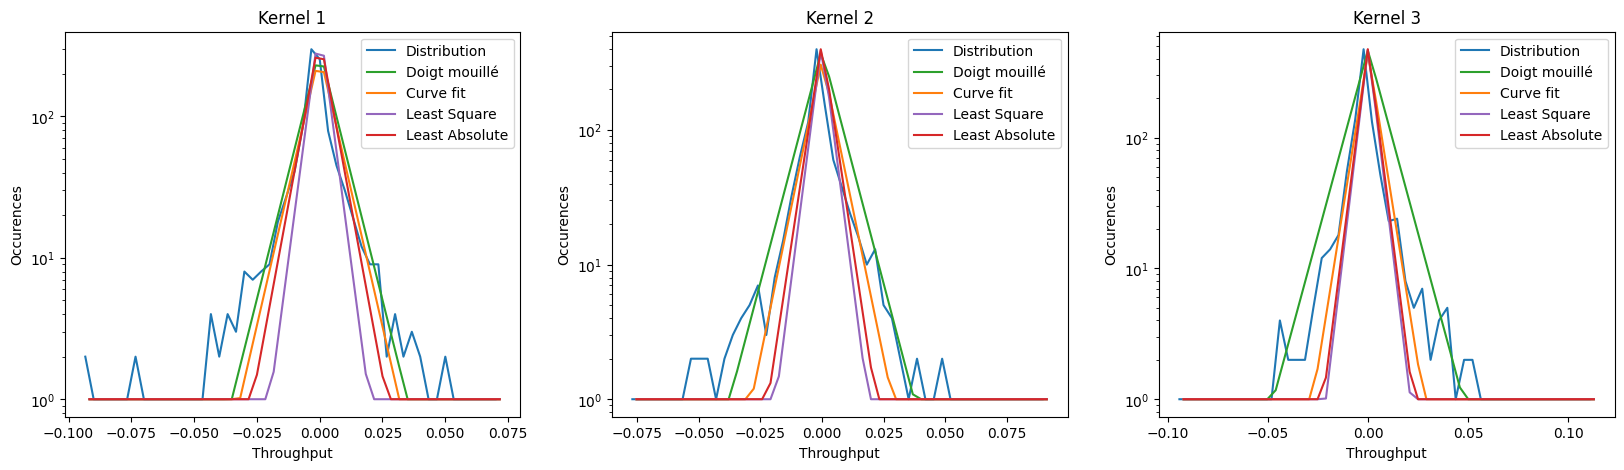

In [16]:
from scipy.optimize import minimize

def gauss(x, a, m, s):
    return a/(s*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-m)/s)**2)

def lorentz(x, a, m, s):
    return a * s/(np.pi*((x-m)**2+s**2))

def lorentz3(x, a, m, s, n):
    return a * s/(np.pi*(np.abs((x-m)**3)+s**3))

def f(x, a, s):
    r = a * np.exp(-np.abs(x)/s)
    r[r<1] = 1
    return r

def fit_kernels(kernels, k=0):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    for k in range(3):
        n, bins = np.histogram(kernels[:,k], bins=50)
        n[n<1] = 1
        axs[k].plot(bins[:-1], n, label='Distribution', color='tab:blue')

        x = (bins[:-1] + bins[1:]) / 2

        # # Gauss
        # popt, pcov = curve_fit(gauss, bins[:-1], n, p0=[np.max(n), 0, np.std(bins)], maxfev=10000)
        # g = gauss(x, *popt)
        # g[g<1] = 1
        # axs[k].plot(x, g, label='Gaussian fit', color='tab:red')

        # # Lorentz
        # popt, pcov = curve_fit(lorentz, bins[:-1], n, p0=[np.max(n), 0, np.std(bins)], maxfev=10000)
        # l = lorentz(x, *popt)
        # l[l<1] = 1
        # axs[k].plot(x, l, label='Lorentzian fit', color='tab:green')

        # # Lorentz 3
        # popt, pcov = curve_fit(lorentz3, bins[:-1], n, p0=[np.max(n), 0, np.std(bins), 3], maxfev=10000)
        # l3 = lorentz3(x, *popt)
        # l3[l3<1] = 1
        # axs[k].plot(x, l3, label='Lorentzian 3 fit', color='tab:purple')

        axs[k].plot(x, f(x, np.max(n), 1/8*np.std(bins)), label='Doigt mouillé', color='tab:green')

        # Custom
        popt, pcov = curve_fit(f, bins[:-1], n, p0=[np.max(n), 1/8*np.std(bins)], maxfev=10000)
        c = f(x, *popt)
        axs[k].plot(x, c, label='Curve fit', color='tab:orange')
        print("Curve-fit:", popt[-1] / np.std(bins))

        def leastsquare(params, x, y):
            a, b = params
            return np.sum((y - f(x, a, b))**2)
        res = minimize(leastsquare, [np.max(n), 1/8*np.std(bins)], args=(x, n))
        axs[k].plot(x, f(x, *res.x), label='Least Square', color='tab:purple')
        print("Least Square:", res.x[-1] / np.std(bins))

        def cost(params, x, y):
            a, b = params
            return np.sum(np.abs(y - f(x, a, b)))
        res = minimize(cost, [np.max(n), 1/8*np.std(bins)], args=(x, n))
        axs[k].plot(x, f(x, *res.x), label='Least Absolute', color='tab:red')
        print("Least Absolute:", res.x[-1] / np.std(bins))

        axs[k].legend()
        axs[k].set_title(f'Kernel {k+1}')
        axs[k].set_xlabel('Throughput')
        axs[k].set_ylabel('Occurences')
        axs[k].set_yscale('log')
    plt.show()


fit_kernels(H1_GEN_INSTANT_SERIE['kernels'])

## 🟡 Time serie

In [17]:
SCENE_VACUUM_IDEAL = SCENE_IDEAL.copy(input_ce_rms=0*u.nm)

VACUUM_IDEAL_TIME_SERIE, H_RANGE = SCENE_VACUUM_IDEAL.time_serie_observation(nights=1)
OBS_TIME_SERIE, _ = SCENE_OBS.copy(input_ce_rms=10*u.nm).time_serie_observation(nights=1)
GEN_TIME_SERIE, _ = SCENE_GEN.copy(input_ce_rms=10*u.nm).time_serie_observation(nights=1)

# Normalization
for output in VACUUM_IDEAL_TIME_SERIE.keys():
    VACUUM_IDEAL_TIME_SERIE[output] /= STAR_FLUX * ΔT
    GEN_TIME_SERIE[output] /= STAR_FLUX * ΔT
    OBS_TIME_SERIE[output] /= STAR_FLUX * ΔT

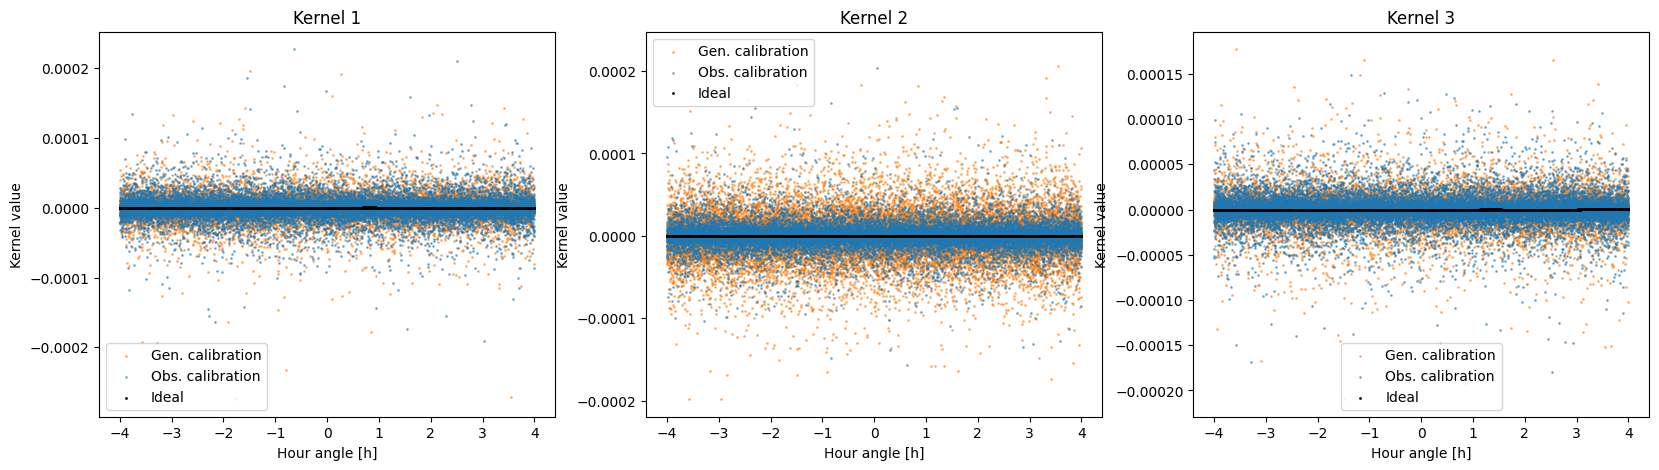

In [18]:
def plot_time_serie():
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    for k in range(3):
        axs[k].set_title(f'Kernel {k+1}')
        for night in range(VACUUM_IDEAL_TIME_SERIE['kernels'].shape[0]):
            axs[k].scatter(H_RANGE, GEN_TIME_SERIE['kernels'][night,:,k], label='Gen. calibration', color='tab:orange', s=1, alpha=0.5)
            axs[k].scatter(H_RANGE, OBS_TIME_SERIE['kernels'][night,:,k], label='Obs. calibration', color='tab:blue', s=1, alpha=0.5)
            axs[k].scatter(H_RANGE, VACUUM_IDEAL_TIME_SERIE['kernels'][night,:,k], label='Ideal', color='k', s=1)
        axs[k].set_xlabel('Hour angle [h]')
        axs[k].set_ylabel('Kernel value')
        axs[k].legend()
    plt.show()
plot_time_serie()

d:\Tunable-Kernel-Nulling\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Tunable-Kernel-Nulling\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


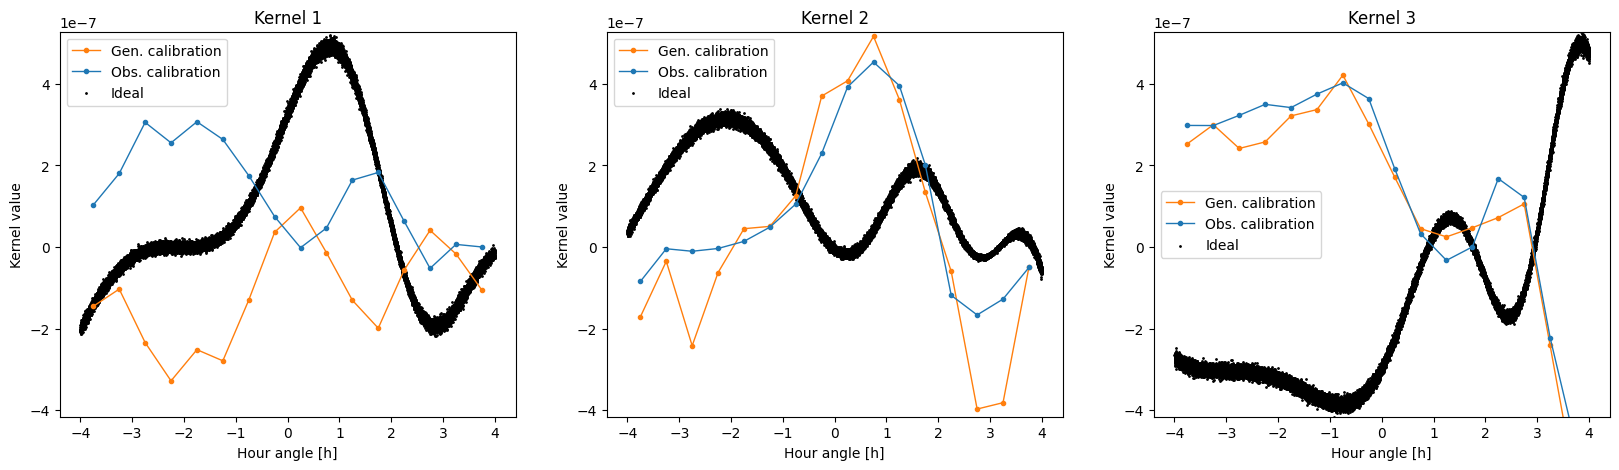

In [26]:
def plot_median_time_serie(window):

    nb_points_in_window = int(window.to(u.hour).value / ΔT.to(u.hour).value)
    nb_widows = int(ΔH.to(u.hourangle).value / window.to(u.hour).value)

    mx = 0
    mn = 0

    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    for k in range(3):
        axs[k].set_title(f'Kernel {k+1}')
        for night in range(VACUUM_IDEAL_TIME_SERIE['kernels'].shape[0]):

            # Median
            h_range_medians = np.zeros(nb_points_in_window) * H_RANGE.unit
            gen_medians = np.zeros(nb_points_in_window)
            obs_medians = np.zeros(nb_points_in_window)

            for i in range(nb_points_in_window):
                h_range_medians[i] = np.median(H_RANGE[i*nb_points_in_window:(i+1)*nb_points_in_window])
                gen_medians[i] = np.median(GEN_TIME_SERIE['kernels'][night,i*nb_points_in_window:(i+1)*nb_points_in_window,k])
                obs_medians[i] = np.median(OBS_TIME_SERIE['kernels'][night,i*nb_points_in_window:(i+1)*nb_points_in_window,k])

            axs[k].plot(h_range_medians, gen_medians, marker='.', color='tab:orange', linewidth=1, alpha=1, label='Gen. calibration')
            axs[k].plot(h_range_medians, obs_medians, marker='.', color='tab:blue', linewidth=1, alpha=1, label='Obs. calibration')
            axs[k].scatter(H_RANGE, VACUUM_IDEAL_TIME_SERIE['kernels'][night,:,k], label='Ideal', color='k', s=1)

            mx = max(
                mx,
                np.max(gen_medians),
                np.max(obs_medians),
                np.max(VACUUM_IDEAL_TIME_SERIE['kernels'])
            )

            mn = min(
                mn,
                np.min(gen_medians),
                np.min(obs_medians),
                np.min(VACUUM_IDEAL_TIME_SERIE['kernels'])
            )

        axs[k].set_ylim(mn, mx)
        axs[k].set_xlabel('Hour angle [h]')
        axs[k].set_ylabel('Kernel value')
        axs[k].legend()
    plt.show()

plot_median_time_serie(window=0.5*u.hour)

---

<div align=center>

# 🔎 **Data analysis**

</div>

## 📢 Noise sensitivity

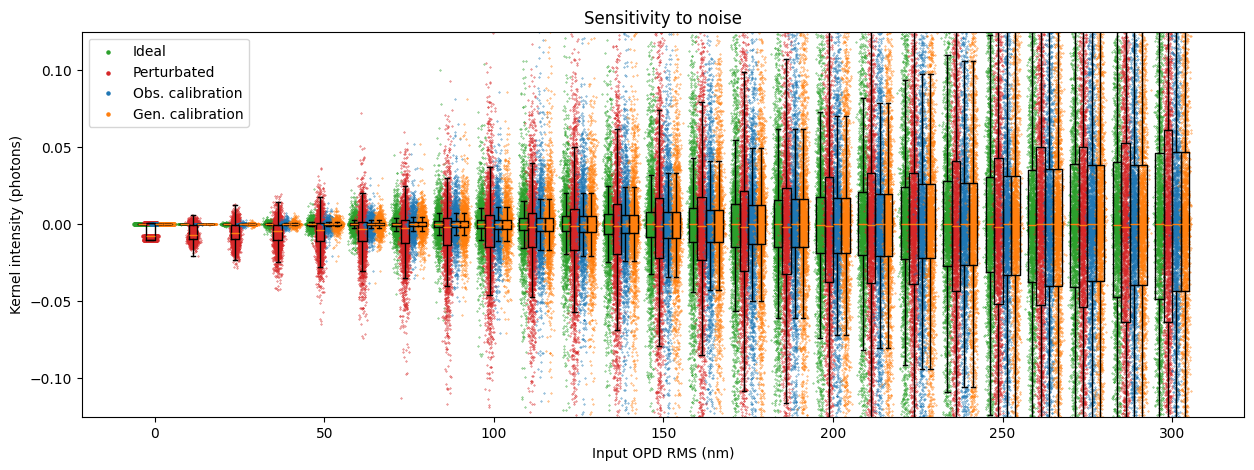

In [20]:
noise_sensitivity.plot(
    scene_ideal=SCENE_IDEAL,
    scene_perturbed=SCENE_PERTURBED,
    scene_obs=SCENE_OBS,
    scene_gen=SCENE_GEN,
    limit=3*SHIFTS_CE_RMS
)

## ☑️ Model fitting (WIP)

Distributions are cool, but in order to make deeper analysis, we want to find a model that describe these distribution using few parameters. Unfortunately, there is no straightforward way to get such model as these distribution are very particular.

The next block try most of the common distribution models and show the best ones... but unfortunately, none of them seems to match 😞

In [21]:
def fit(data):
    f = fitter.Fitter(data,
           distributions=fitter.get_distributions())
    f.fit()
    f.summary()

# fit(IDEAL_INSTANT_SERIE['kernels'][0])

## 📈 Test statistics

A test statistic is a way of reducing the data we have to an unique number and compare this number to a threshold value. If the number is below the treshold, then the null hypothesis is favored. If it is above, the alternative hypothesis is favored. The goal is to find the best test statistic that allow to distinguish both hypothesis in a correct way

- $H0$: the null hypothesis -> there is no planet
- $H1$: the alternative hypothesis -> there is a planet

- $T0$: vector of distributions obtained with H0
- $T1$: vector of distributions obtained with H1

In [22]:
T0, T1, TREF = ts.get_vectors(nmc=1000, size=100, scene_h1=SCENE_IDEAL.copy(input_ce_rms=100*u.nm))

Generation complete ✅


### Mean

**Principle:** We take the average of the distribution and we compare it to a treshold.

$$
\left|\frac{1}{N}\sum_i x_i \right| \stackrel{H_1}{\underset{H_0}{\gtrless}} \xi
$$

### Median

**Principle:** We take the median of the distribution and we compare it to a treshold.

$$
\begin{cases}
\left| x_{\frac{N+1}{2}} \right| & \text{if }N\text{ is odd} \\

\left| \frac{x_{\frac{N}{2}} + x_{\frac{N+1}{2}}}{2} \right|  & \text{if }N\text{ is odd}
\end{cases}
\quad\stackrel{H_1}{\underset{H_0}{\gtrless}} \xi
$$

### Argmax

**Principle:** We pack our data in bins and we consider the position of the bin with the highest number of occurences. We compare it to a treshold.

### Kolmogorov-Smirnov

**Principle:** We compare the maximum distance on the cumulative distribution functions of the two distributions.

### Cramèr-von Mises

**Principle:** We compare the total quadratique distance on the cumulative distribution functions of the two distributions.

### Wilcoxon-Mann-Whitney (WIP)

### CDF diff area (Aurélie's idea)

In [23]:
TEST_STATISTICS = {
    'Mean': ts.mean,
    'Median': ts.median,
    # 'argmax50': ts.argmax50,
    # 'argmax100': ts.argmax100,
    'Argmax500': ts.argmax500,
    'Kolmogorov-Smirnov': ts.kolmogorov_smirnov,
    'Cramer Von Mises': ts.cramer_von_mises,
    'Wilcoxon Mann Whitney': ts.wilcoxon_mann_whitney,
    'CDF Diff. Area': ts.cdf_diff_area
}

## ❓ ROC curves

ROC curves allow to compare the power of different test statistics. It show the proportion of true detection in function of the probability of false alarm. The more the curve climb fast, the better it is.

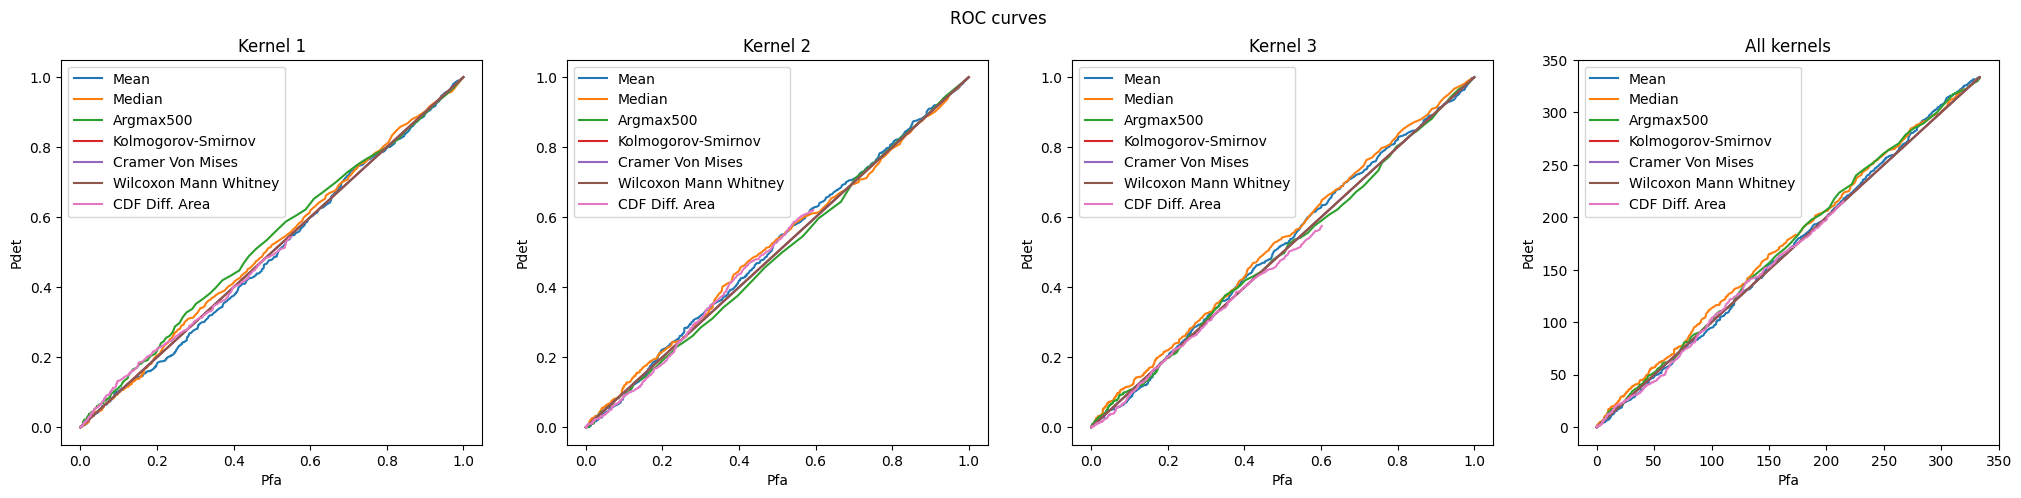

In [24]:
ts.plot_roc(t0=T0, t1=T1, tref=TREF, test_statistics=TEST_STATISTICS)

## 💪 P-values

The P-value is an indicator of the confidence we have to reject the null hypothesis.

The principle consist in comparing the test statistic obtain on the data we want to test with a large bunch of data that we know to be under the null hypothesis. We then compute the proportion of test statistic that are above the one we obtained. This proportion is the P-value.

Thus, the lower the P-value, the more confident we are to reject the null hypothesis. A P-value below 0.05 is commonly considered as a good indicator to reject the null hypothesis.

In [25]:
ts.plot_p_values(test_statistics=TEST_STATISTICS, t0=T0, tref=TREF)

TypeError: plot_p_values() got an unexpected keyword argument 't0'

---

<div align=center>

# 🪐 **Characterization**

</div>

## 🔄️ Angular diversity

In order to determine the planet position, we need to rotate the interferometer baseline in order to rotate the transmission map. Thus, the planet signal will be modulated. By analysis this modulation (trying to fit the parametrized modulation function to the data points), it is possible to retrieve the planet position.

In [ ]:
@nb.njit()
def kernels_modulation_njit(
    h_range:np.ndarray[float]=H_RANGE.to(u.rad).value,
    alpha:float=PARALLACTIC_ANGLE.to(u.rad).value,
    theta:float=ANGULAR_SEPARATION.to(u.rad).value,
    # contrast:float=CONTRAST
) -> np.ndarray[float]:
    """
    Compute the modulation of the kernels with respect to the hour angle

    Parameters
    ----------
    - h_range: The range of hour angles to consider (in radian)
    - alpha: Parallactic angle (in radian)
    - theta: Angular separation (in radian)
    - contrast: The contrast value

    Returns
    -------
    - The modulation of the kernels.
    """

    kernels_mod = np.zeros((3, len(h_range)))
    for h, dh in enumerate(h_range):

        projected_telescope_position = project_position_njit(h=dh)

        signals = get_input_fields_njit(
            norm=PLANET_FLUX,
            projected_telescope_positions=projected_telescope_position,
            parallactic_angle=alpha,
            angular_separation=theta,
        )

        _, kernels, _ = kn_njit(
            signals,
            shifts=np.zeros(14),
            shifts_total_opd=np.zeros(14),
        )

        for i in range(3):
            kernels_mod[i, h] = kernels[i] * CONTRAST * OPTICAL_EFFICIENCY

    return kernels_mod

def kernels_modulation(
    h_range:u.Quantity=H_RANGE,
    alpha:u.Quantity=PARALLACTIC_ANGLE,
    theta:u.Quantity=ANGULAR_SEPARATION,
    # contrast:float=CONTRAST
):
    return kernels_modulation_njit(h_range.to(u.rad).value, alpha.to(u.rad).value, theta.to(u.rad).value) # , contrast)

kernel_modulation = [lambda h,a,t: kernels_modulation(h,a,t)[i] for i in range(3)]
kernel_modulation_njit = [lambda h,a,t: kernels_modulation_njit(h,a,t)[i] for i in range(3)]

In [ ]:
def iplot_kernels_modulation():
    alpha_slider = widgets.FloatSlider(value=PARALLACTIC_ANGLE.value, min=0, max=2*np.pi, step=2*np.pi/1000, description=f'Alpha (rad)')
    theta_slider = widgets.FloatSlider(value=ANGULAR_SEPARATION.value, min=0, max=FOV.value, step=FOV.value/1000, description=f'Theta ({FOV.unit})')
    contrast_slider = widgets.FloatSlider(value=int(np.log10(CONTRAST)), min=-10, max=0, step=1, description=f'Contrast')
    plot = widgets.Image()
    reset = widgets.Button(description="Reset")

    def update_plot(*args):
        kms = kernels_modulation(H_RANGE, alpha_slider.value*u.rad, (theta_slider.value*FOV.unit).to(u.rad)) # , 10**contrast_slider.value

        fig, axs = plt.subplots(1, 3, figsize=(20, 3))

        for i in range(3):
            ax = axs[i]
            ax.plot(H_RANGE, kms[i])
            ax.set_title(f"Kernel {i+1}")
            ax.set_xlabel("Hour angle (rad)")
            ax.set_ylabel("Intensity")  

        buffer = BytesIO()
        plt.savefig(buffer, format='png')
        plot.value = buffer.getvalue()
        plt.close()

    def reset_values(*args):
        alpha_slider.value = PARALLACTIC_ANGLE.value
        theta_slider.value = ANGULAR_SEPARATION.value
        contrast_slider.value = int(np.log10(CONTRAST))

    alpha_slider.observe(update_plot)
    theta_slider.observe(update_plot)
    contrast_slider.observe(update_plot)
    reset.on_click(reset_values)

    update_plot()
    display(widgets.VBox([alpha_slider, theta_slider, contrast_slider, plot, reset]))

iplot_kernels_modulation()

In [ ]:
def plot_hour_diversity(
        data=HOUR_DIVERSITY_DATA,
        h_range=H_RANGE,
    ):

    fits = np.zeros((3, len(h_range)))

    print("Param    = Ideal | First guess | Found")
    print("======================================")

    popts = []
    for i in range(3):
        # Fit data to kernels modulations
        p0 = [PARALLACTIC_ANGLE.value + np.random.normal(0,0.1*np.pi), (ANGULAR_SEPARATION + np.random.normal(0,0.2)*u.mas).to(u.rad).value] # , CONTRAST * np.random.normal(1,0.1)

        popt, pcov = curve_fit(
            kernel_modulation_njit[i],
            h_range.value,
            data[i],
            p0=p0,
            maxfev=10000
        )

        print(f"Alpha    = {PARALLACTIC_ANGLE.to(u.deg):.2f} | {(p0[0]*u.rad).to(u.deg):.2f} | {(popt[0]*u.rad).to(u.deg):.2f}")
        print(f"Theta    = {ANGULAR_SEPARATION.to(u.mas):.2f} | {(p0[1]*u.rad).to(u.mas):.2f} | {(popt[1]*u.rad).to(u.mas):.2f}")
        # print(f"Contrast = {CONTRAST:.2e} | {p0[2]:.2e} | {popt[2]:.2e}")
        print("---")
        popts.append(popt)
    popt = np.mean(popts, axis=0)

    _, axs = plt.subplots(3, 1, figsize=(15, 15))
    for i in range(3):
        fits[i] = kernels_modulation_njit(h_range.to(u.rad).value, *popt)[i]

        ax = axs[i]

        ax.scatter(h_range, data[i], label="Data",alpha=0.5)
        ax.plot(h_range, kernels_modulation_njit(h_range.to(u.rad).value)[i], "--", label="Expected signal")
        ax.plot(h_range, kernels_modulation_njit(h_range.to(u.rad).value, *popts[i])[i], label="Specific fit")
        ax.plot(h_range, fits[i], label="Global fit")

        ax.set_xlabel("Observation time (hour)")
        ax.set_ylabel("Kernel intensity")
        ax.set_title(f"Kernel {i+1}")
        ax.legend()

    plt.show()

    print("Param    = Ideal | Found")
    print("========================")
    print(f"Alpha    = {PARALLACTIC_ANGLE.to(u.deg):.2f} | {(popt[0]*u.rad).to(u.deg):.2f}")
    print(f"Theta    = {ANGULAR_SEPARATION.to(u.mas):.2f} | {(popt[1]*u.rad).to(u.mas):.2f}")
    # print(f"Contrast = {CONTRAST:.2e} | {popt[2]:.2e}")

plot_hour_diversity()

## 🌌 On-sky contribution

From the obtained data, it is possible to build a 2D distribution of the perceived sky contribution zones. This distribution provides insights into the possible locations of objects, enabling accurate initial estimations to fit the data points obtained based on the parallactic angle.

This method involves stacking the transmission maps rotated by the baseline rotation and weighting each map by the corresponding data obtained for that baseline rotation.

The base idea was already explored as "image reconstruction" technic using classical nulling interferometry $^1$. However, the method here is based on Kernel-Nulls which makes it more complex but less sensitive to phase aberations and by considerig the different Kernels, we can reduce the degeneracy of the solutions.

Considering:
- $T_{n}$ represents the n-th kernel's normalized transmission map.
- $d_{n,\beta}$ denotes the data point obtained for kernel $n$ with baseline rotation $\beta$.
- $\alpha$ is the parallactic angle.
- $\theta$ is the angular separation.

$$
r_n(\theta, \alpha) = \sum_a T_{n,h}(\theta,\alpha) d_{n,h}
$$


As the kernel outputs are antisymetric, we can filter the negative contributions:
$$
r'_n = \frac{1}{2}(r_n+|r_n|)
$$


Finally, we can compute the product over all the kernels to get the final contribution zones:
$$
C(\theta, \alpha) = \prod_n r'_n(\theta, \alpha)
$$

**References:**
1. Angel, J. R. P., et N. J. Woolf. "An Imaging Nulling Interferometer to Study Extrasolar Planets". *The Astrophysical Journal* 475, no 1 (1997): 373‑79. https://doi.org/10.1086/303529.

In [ ]:
def plot_contribution_zones(
    data: np.ndarray[float] = HOUR_DIVERSITY_DATA,
    fov: u.Quantity = FOV,
    resolution: int = 100,
):

    images = np.zeros((3, resolution, resolution))
    integrated_kernels = np.zeros((3, resolution, resolution))

    _, _, theta_map, _ = get_uv_map(resolution=resolution, fov=fov)
    _, _, kernel_maps = get_transmission_map(resolution=resolution)
    theta_map = theta_map.value / np.max(theta_map.value)

    for i, h in enumerate(H_RANGE):

        for j in range(3):
            projected_telescope_position = project_position(h=h)
            tm = get_transmission_map(projected_telescope_positions=projected_telescope_position)[2][j]
            integrated_kernels[j] += np.abs(tm) #* theta_map
            images[j] += tm * data[j, i] #* theta_map

    for i in range(3):
        integrated_kernel_intensity = np.sum(integrated_kernels[i])
        kernel_intensity = np.sum(np.abs(kernel_maps[i]))

        normalization_factor = integrated_kernel_intensity / kernel_intensity

        print(f"Kernel {i+1} : {integrated_kernel_intensity:.2e} / {kernel_intensity:.2e} = {normalization_factor:.2e}")

        images[i] /= normalization_factor

    max_im = np.max(images)

    _, axs = plt.subplots(1, 4, figsize=(25, 5))

    planet_x, planet_y = αθ_to_xy()

    for i in range(3):
        img = images[i]
        img[img < 0] = 0
        im = axs[i].imshow(img, cmap="hot", vmax=max_im, extent=EXTENT)
        axs[i].set_title(f"Kernel {i+1}")
        plt.colorbar(im, ax=axs[i])
        axs[i].scatter(planet_x, planet_y, marker="+", color="white")

    # Take mean of probable input flux
    img = np.mean(images, axis=0)

    # Filter where a probability of flux is null on one of the kernels
    images[images < 0] = 0
    mask = np.prod(images, axis=0)
    img = img * mask / np.max(mask)

    # Plot reconstructed image
    im = axs[3].imshow(img, cmap="hot", extent=EXTENT)
    axs[3].set_title("Contribution zones")
    plt.colorbar(im, ax=axs[3])
    axs[3].scatter(planet_x, planet_y, marker="+", color="white")

    plt.show()

plot_contribution_zones()

## ♒ Correlation map (WIP)

In [ ]:
def correlation_map(
        data=HOUR_DIVERSITY_DATA,
        h_range=H_RANGE,
    ):

    resolution = 20
    
    _, _, alpha_map, theta_map = get_uv_map(resolution=resolution)

    correl_map = np.zeros((resolution, resolution))

    for x in range(resolution):
        for y in range(resolution):

            alpha = alpha_map[x, y]
            theta = theta_map[x, y]

            km = kernels_modulation(h_range, alpha=alpha, theta=theta)[0]

            correl_map[x, y] = np.sum(np.corrcoef(data[0], km))


    _, ax = plt.subplots(1, 1, figsize=(15, 15))
    im = ax.imshow(correl_map)
    plt.colorbar(im, ax=ax)
    ax.set_title("Correlation map")

    plt.show()

correlation_map()